## 📦 Instalación de Librerías Necesarias

**Antes de ejecutar este notebook, asegúrate de tener instaladas todas las dependencias.**

### Opción 1: Instalación dentro del notebook
Ejecuta la siguiente celda para instalar las librerías necesarias:

```python
%pip install pandas numpy matplotlib seaborn
```

### Opción 2: Instalación desde terminal
Si prefieres instalar desde la terminal, ejecuta:

```bash
# PowerShell o CMD
pip install pandas numpy matplotlib seaborn

# O si usas el proyecto completo con pyproject.toml
pip install -e .[core,notebooks]
```

### Librerías requeridas:
- `pandas`: Manipulación y análisis de datos
- `numpy`: Cálculos numéricos y arrays
- `matplotlib`: Visualización estática
- `seaborn`: Visualización estadística avanzada

---

---
id: "BA-01"
title: "Dashboard de OTIF (On-Time In-Full)"
specialty: "Business Analytics"
process: "Deliver"
level: "Intermediate"
tags: ["otif", "kpi", "delivery", "logistics", "dashboard"]
estimated_time_min: 50
---

In [4]:
# ⚙️ Preparación de entorno y rutas
# Si esta celda tarda demasiado o se cuelga:
# 1) Abre la paleta de comandos (Ctrl+Shift+P)
# 2) "Jupyter: Restart Kernel"
# 3) "Run All Above/Below" o ejecuta desde la primera celda

import sys
from pathlib import Path

# Detectar raíz del repo (buscando pyproject.toml o carpeta src)
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()

if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))

print(f"✅ Entorno listo. Raíz del repo: {_repo_root}")

✅ Entorno listo. Raíz del repo: f:\GitHub\supply-chain-data-notebooks


# BA-01: Dashboard de OTIF (On-Time In-Full)

## 📋 Contexto del Caso de Negocio

**Empresa:** "LogiPro 3PL" - Operador logístico que gestiona distribución para 8 clientes B2B en sector retail.

**Situación:** El cliente más importante ("MegaRetail") se queja de entregas tardías e incompletas. El gerente comercial necesita:
- Medir objetivamente el desempeño OTIF por cliente
- Identificar patrones: ¿qué días/rutas/regiones fallan más?
- Entender causas raíz: retrasos en transporte vs problemas de picking
- Reportar mensualmente al comité directivo con evidencia

**Objetivo:** Construir un dashboard analítico de OTIF con drill-down por cliente, región, ruta y análisis de causas.

---

## 🎯 Qué - Por qué - Para qué - Cuándo - Cómo

### ❓ ¿QUÉ estamos haciendo?
Construyendo un **análisis integral del KPI OTIF** (On-Time In-Full):
- **On-Time:** Entrega dentro de la ventana horaria comprometida
- **In-Full:** Cantidad entregada = cantidad solicitada (sin faltantes)
- **OTIF:** Cumplimiento simultáneo de ambas condiciones

**Fórmula:** `OTIF% = (Órdenes On-Time AND In-Full) / Total Órdenes * 100`

### 🔍 ¿POR QUÉ es importante?
- **Retención de clientes:** El 89% de clientes B2B considera OTIF en renovación de contratos
- **Penalizaciones:** Contratos típicos descuentan 0.5-2% por cada punto bajo 95% OTIF
- **Competitividad:** Operadores clase mundial mantienen OTIF >97%
- **Diagnóstico operacional:** Separa problemas de almacén vs transporte

### 🎁 ¿PARA QUÉ sirve?
- **Negociación comercial:** Datos objetivos para discutir penalizaciones o bonos
- **Priorización operativa:** Focalizar mejora en clientes/rutas críticas
- **Análisis de causas:** Identificar si el problema es capacidad, procesos o planificación
- **Benchmarking:** Comparar desempeño entre clientes, CDs, transportistas

### ⏰ ¿CUÁNDO aplicarlo?
- **Diariamente:** Monitoreo operativo de entregas del día
- **Semanalmente:** Revisión con supervisores para correcciones tácticas
- **Mensualmente:** Reporte a clientes y comité directivo
- **Ad-hoc:** Ante reclamos de clientes o auditorías

### 🛠️ ¿CÓMO lo hacemos?
1. **Integrar datos:** Órdenes + eventos de entrega + ventanas horarias
2. **Calcular componentes:** On-Time %, In-Full %, OTIF %
3. **Segmentar:** Por cliente, región, ruta, día de semana
4. **Analizar causas:** Clasificar incumplimientos (retraso transporte, faltantes picking, etc.)
5. **Visualizar:** Gráficos de tendencia, heatmaps, Pareto de causas
6. **Generar insights:** Recomendaciones accionables

In [ ]:
# 📚 CONCEPTO: Librerías para Business Analytics y dashboards
# - pandas: manipulación de datos (cálculo de KPIs, agregaciones)
# - numpy: operaciones numéricas y generación de datos sintéticos
# - matplotlib/seaborn: visualización de KPIs (barras, líneas, heatmaps)
# - warnings: suprimir advertencias no críticas en notebooks

# 💡 INTERPRETACIÓN: ¿Por qué warnings.filterwarnings('ignore')?
# En notebooks interactivos, advertencias de versiones de librerías pueden
# saturar la salida. En producción, NUNCA suprimir warnings (pueden indicar
# deprecations o problemas de compatibilidad).

# 🔍 TÉCNICA: Configuración visual consistente
# - sns.set_style('whitegrid'): fondo blanco con grilla sutil (estándar corporativo)
# - sns.set_palette('Set2'): paleta de colores amigable (no saturada, apta para daltónicos)
# - figsize=(14, 6): aspecto horizontal óptimo para pantallas widescreen

# Imports necesarios
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_palette('Set2')

print("✅ Librerías cargadas")


✅ Librerías cargadas


## 📥 Paso 1: Cargar y preparar datos de entregas

Simulamos datos de órdenes con información de entregas y ventanas horarias.

In [7]:
# Cargar datos
data_path = Path('../../data/raw')
df_orders = pd.read_csv(data_path / 'orders.csv')
df_orders['date'] = pd.to_datetime(df_orders['date'])
df_transport = pd.read_csv(data_path / 'transport_events.csv')
df_transport['timestamp'] = pd.to_datetime(df_transport['timestamp'])
df_locations = pd.read_csv(data_path / 'locations.csv')

print(f"📦 Órdenes cargadas: {len(df_orders):,}")
print(f"🚚 Eventos transporte: {len(df_transport):,}")
print(f"📍 Ubicaciones: {len(df_locations):,}")
print(f"\n📋 Columnas en orders: {list(df_orders.columns)}")
print(f"📋 Columnas en transport: {list(df_transport.columns)}")

📦 Órdenes cargadas: 8,504
🚚 Eventos transporte: 2,995
📍 Ubicaciones: 30

📋 Columnas en orders: ['order_id', 'date', 'sku', 'qty', 'location_id', 'channel']
📋 Columnas en transport: ['event_id', 'order_id', 'status', 'lat', 'lon', 'timestamp']


In [8]:
# Simular datos adicionales necesarios para OTIF
np.random.seed(42)

# Agregar clientes B2B y ventanas de entrega
clientes_b2b = ['MegaRetail', 'SuperTiendas', 'FarmaPlus', 'ElectroMax', 
                'ModaStore', 'HogarCenter', 'TechWorld', 'BeautyChain']

df_orders['customer'] = np.random.choice(clientes_b2b, len(df_orders), 
                                          p=[0.25, 0.18, 0.15, 0.12, 0.10, 0.08, 0.07, 0.05])

# Simular fecha prometida (2-5 días después de la orden)
df_orders['promised_date'] = df_orders['date'] + pd.to_timedelta(
    np.random.choice([2, 3, 4, 5], len(df_orders)), unit='D'
)

# Simular fecha/hora de entrega real (algunos con retraso)
df_orders['delivery_date'] = df_orders['promised_date'] + pd.to_timedelta(
    np.random.choice([0, 1, 2, 3], len(df_orders), p=[0.75, 0.15, 0.07, 0.03]), unit='D'
)

# Simular cantidad entregada (algunos con faltantes)
df_orders['qty_delivered'] = df_orders['qty'].apply(
    lambda x: x if np.random.random() > 0.12 else int(x * np.random.uniform(0.7, 0.95))
)

# Agregar región desde ubicaciones
df_orders = df_orders.merge(
    df_locations[['location_id', 'region']], 
    left_on='location_id', 
    right_on='location_id', 
    how='left'
)

print("✅ Datos preparados para análisis OTIF")
print(f"\n🔍 Distribución de clientes:")
print(df_orders['customer'].value_counts())

✅ Datos preparados para análisis OTIF

🔍 Distribución de clientes:
customer
MegaRetail      2192
SuperTiendas    1536
FarmaPlus       1270
ElectroMax      1040
ModaStore        784
HogarCenter      694
TechWorld        566
BeautyChain      422
Name: count, dtype: int64


## 📊 Paso 2: Calcular componentes OTIF

Calculamos los tres componentes: On-Time, In-Full y OTIF.

In [ ]:
# 📚 CONCEPTO: KPI OTIF (On-Time In-Full) - métrica crítica en logística
# OTIF es un KPI compuesto de dos componentes independientes:
# 1. On-Time: Entrega dentro de la ventana horaria prometida
# 2. In-Full: Cantidad entregada = cantidad solicitada
# OTIF = 1 SOLO SI ambos se cumplen (operador lógico AND)

# 💡 INTERPRETACIÓN: ¿Por qué OTIF es tan exigente?
# Fórmula: OTIF% = (Órdenes con on_time=1 Y in_full=1) / Total órdenes
# Si una orden llega a tiempo pero incompleta → OTIF=0
# Si una orden llega completa pero tarde → OTIF=0
# Esta severidad refleja la realidad operacional:
# - Un retail que recibe 90% de mercancía a tiempo no puede abrir su tienda.
# - Un hospital que recibe medicamentos tarde puede poner en riesgo vidas.

# 🔍 TÉCNICA: Operadores booleanos con &
# En pandas, usar & (bitwise AND) en lugar de 'and' (logical AND):
# - df['otif'] = (df['on_time'] & df['in_full']).astype(int)
# - Paréntesis obligatorios por precedencia de operadores
# - .astype(int) convierte True/False → 1/0 para facilitar .mean()

# 🎯 APLICACIÓN: Benchmarks industriales de OTIF
# - Clase mundial (tier 1): >97% OTIF
# - Competitivo (tier 2): 95-97% OTIF
# - En riesgo (tier 3): 90-95% OTIF
# - Crítico: <90% OTIF (riesgo de pérdida de contratos)
# Penalizaciones contractuales típicas: 0.5-2% descuento por cada punto bajo 95%

# ⚠️ SUPUESTO: Ventana horaria de entrega de 1 día (simplificación)
# En producción, ventanas son más estrictas:
# - B2C (e-commerce): ventana de 2-4 horas (AM/PM)
# - B2B (retail): ventana de 1 hora (evitar costos de espera de camión)
# - Hospitales: ventana de 15-30 minutos (criticidad de insumos médicos)

# Calcular componentes OTIF
df_orders['on_time'] = (df_orders['delivery_date'] <= df_orders['promised_date']).astype(int)
df_orders['in_full'] = (df_orders['qty_delivered'] >= df_orders['qty']).astype(int)
df_orders['otif'] = (df_orders['on_time'] & df_orders['in_full']).astype(int)

# Calcular días de retraso
df_orders['days_late'] = (df_orders['delivery_date'] - df_orders['promised_date']).dt.days
df_orders['days_late'] = df_orders['days_late'].clip(lower=0)

# Calcular % cumplimiento cantidad
df_orders['fill_rate'] = (df_orders['qty_delivered'] / df_orders['qty'] * 100).round(1)

# KPIs generales
total_orders = len(df_orders)
on_time_pct = df_orders['on_time'].mean() * 100
in_full_pct = df_orders['in_full'].mean() * 100
otif_pct = df_orders['otif'].mean() * 100

print("📊 KPIs OTIF Generales:")
print(f"  Total órdenes analizadas: {total_orders:,}")
print(f"  On-Time %: {on_time_pct:.2f}%")
print(f"  In-Full %: {in_full_pct:.2f}%")
print(f"  ⭐ OTIF %: {otif_pct:.2f}%")
print(f"\n🎯 Meta industria clase mundial: >97% OTIF")
print(f"📊 Brecha vs meta: {97 - otif_pct:.2f} puntos porcentuales")


📊 KPIs OTIF Generales:
  Total órdenes analizadas: 8,504
  On-Time %: 74.40%
  In-Full %: 88.10%
  ⭐ OTIF %: 65.72%

🎯 Meta industria clase mundial: >97% OTIF
📊 Brecha vs meta: 31.28 puntos porcentuales


## 🏢 Paso 3: Análisis OTIF por Cliente

Identificar qué clientes tienen mejor/peor desempeño.

In [10]:
# OTIF por cliente
otif_by_customer = df_orders.groupby('customer').agg({
    'order_id': 'count',
    'on_time': 'mean',
    'in_full': 'mean',
    'otif': 'mean',
    'days_late': 'mean'
}).round(4)

otif_by_customer.columns = ['Total_Orders', 'OnTime_%', 'InFull_%', 'OTIF_%', 'Avg_Days_Late']
otif_by_customer = otif_by_customer * [1, 100, 100, 100, 1]  # Convertir a porcentajes
otif_by_customer = otif_by_customer.sort_values('OTIF_%', ascending=False).round(2)

print("📊 OTIF por Cliente (ordenado por mejor desempeño):\n")
print(otif_by_customer)

# Identificar cliente crítico
worst_customer = otif_by_customer['OTIF_%'].idxmin()
worst_otif = otif_by_customer.loc[worst_customer, 'OTIF_%']
print(f"\n🚨 Cliente crítico: {worst_customer} con OTIF de {worst_otif:.2f}%")

📊 OTIF por Cliente (ordenado por mejor desempeño):

              Total_Orders  OnTime_%  InFull_%  OTIF_%  Avg_Days_Late
customer                                                             
HogarCenter            694     76.80     90.06   69.60           0.34
MegaRetail            2192     76.00     88.09   67.06           0.38
TechWorld              566     77.21     87.10   66.43           0.36
ModaStore              784     75.13     86.73   65.43           0.37
SuperTiendas          1536     73.50     88.02   65.36           0.40
ElectroMax            1040     72.69     88.37   64.33           0.41
FarmaPlus             1270     71.81     88.19   63.54           0.43
BeautyChain            422     72.27     88.15   63.27           0.46

🚨 Cliente crítico: BeautyChain con OTIF de 63.27%


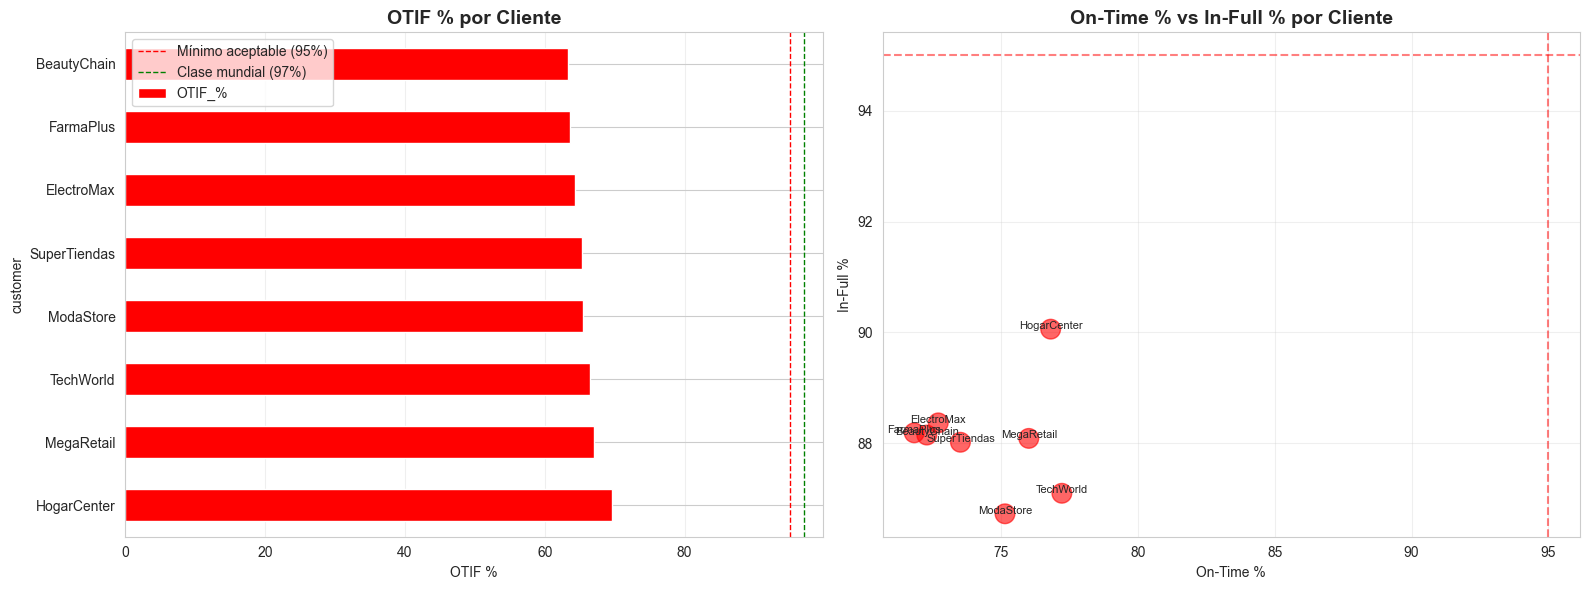

💡 Insight: Clientes en cuadrante inferior izquierdo requieren acción urgente


In [11]:
# Visualización: OTIF por cliente
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Barras de OTIF% por cliente
colors = ['red' if x < 95 else 'orange' if x < 97 else 'green' 
          for x in otif_by_customer['OTIF_%']]
otif_by_customer['OTIF_%'].plot(kind='barh', ax=axes[0], color=colors)
axes[0].axvline(x=95, color='red', linestyle='--', linewidth=1, label='Mínimo aceptable (95%)')
axes[0].axvline(x=97, color='green', linestyle='--', linewidth=1, label='Clase mundial (97%)')
axes[0].set_title('OTIF % por Cliente', fontsize=14, fontweight='bold')
axes[0].set_xlabel('OTIF %')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Gráfico 2: Componentes On-Time vs In-Full
scatter_data = otif_by_customer[['OnTime_%', 'InFull_%']].reset_index()
axes[1].scatter(scatter_data['OnTime_%'], scatter_data['InFull_%'], s=200, alpha=0.6, c=colors)
for idx, row in scatter_data.iterrows():
    axes[1].annotate(row['customer'], (row['OnTime_%'], row['InFull_%']), 
                    fontsize=8, ha='center')
axes[1].axhline(y=95, color='red', linestyle='--', alpha=0.5)
axes[1].axvline(x=95, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('On-Time % vs In-Full % por Cliente', fontsize=14, fontweight='bold')
axes[1].set_xlabel('On-Time %')
axes[1].set_ylabel('In-Full %')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Insight: Clientes en cuadrante inferior izquierdo requieren acción urgente")

## 🗺️ Paso 4: Análisis OTIF por Región

Identificar si hay patrones geográficos en incumplimientos.

In [12]:
# OTIF por región
otif_by_region = df_orders.groupby('region').agg({
    'order_id': 'count',
    'otif': 'mean',
    'on_time': 'mean',
    'in_full': 'mean',
    'days_late': 'mean'
}).round(4)

otif_by_region.columns = ['Total_Orders', 'OTIF_%', 'OnTime_%', 'InFull_%', 'Avg_Days_Late']
otif_by_region = otif_by_region * [1, 100, 100, 100, 1]
otif_by_region = otif_by_region.sort_values('OTIF_%', ascending=False).round(2)

print("🗺️ OTIF por Región:\n")
print(otif_by_region)

# Región más problemática
worst_region = otif_by_region['OTIF_%'].idxmin()
print(f"\n📍 Región con menor OTIF: {worst_region} ({otif_by_region.loc[worst_region, 'OTIF_%']:.2f}%)")

🗺️ OTIF por Región:

        Total_Orders  OTIF_%  OnTime_%  InFull_%  Avg_Days_Late
region                                                         
SOUTH           2855   66.34     74.92     88.58           0.39
WEST            1724   66.24     74.83     88.40           0.39
CENTER          1110   66.04     74.68     87.93           0.38
EAST            1368   64.99     74.20     87.79           0.38
NORTH           1447   64.34     72.84     87.21           0.41

📍 Región con menor OTIF: NORTH (64.34%)


## 📅 Paso 5: Análisis Temporal - Tendencias y Estacionalidad

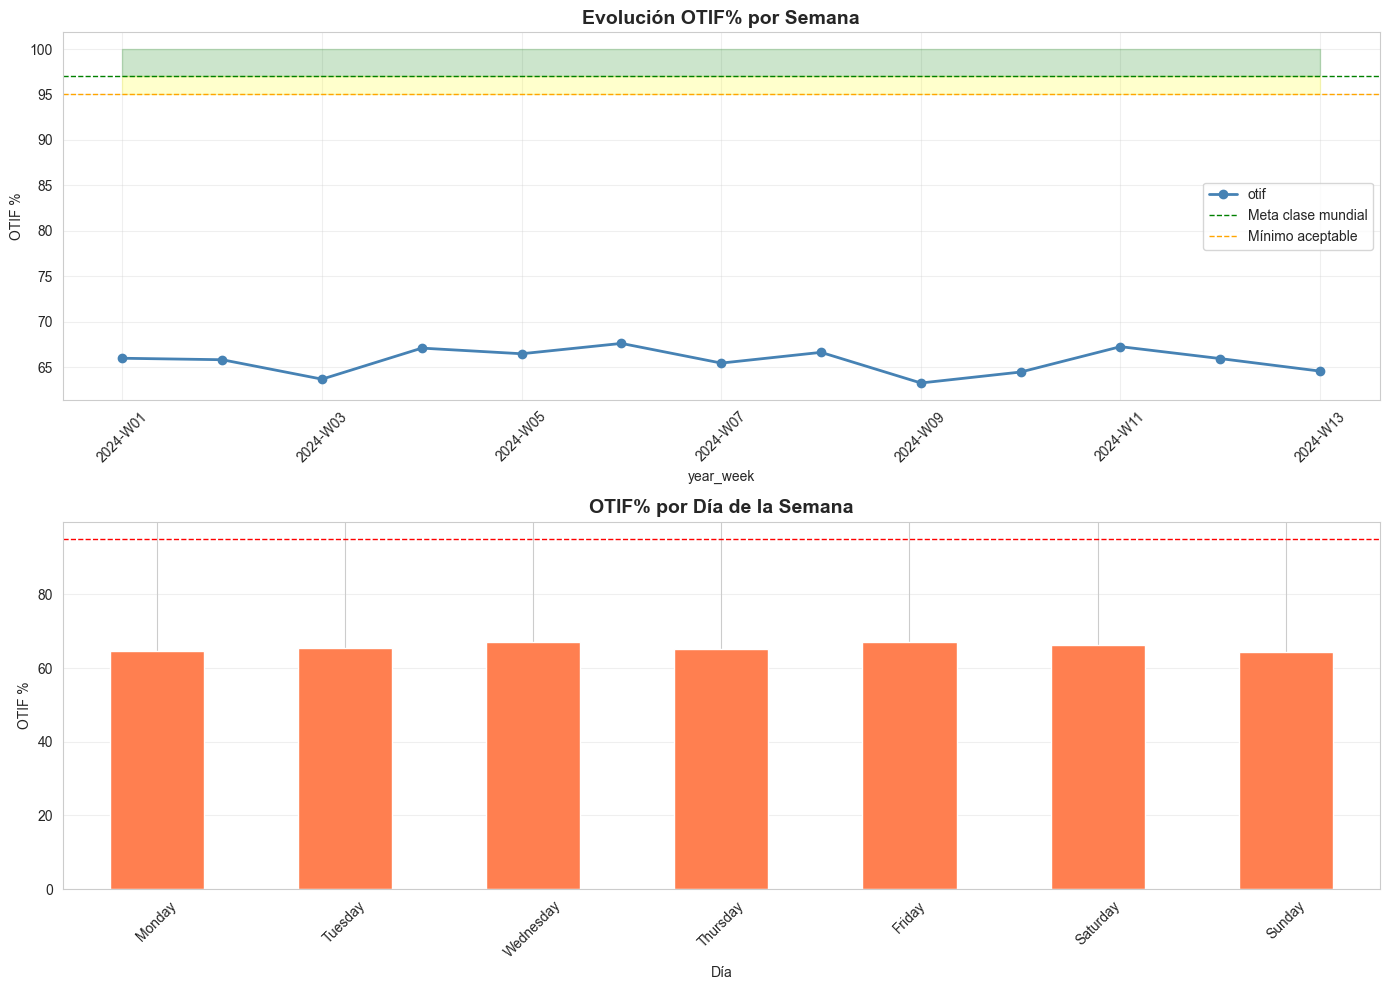

💡 Insight: El día con peor desempeño es Sunday (64.47% OTIF)


In [14]:
# OTIF por semana
df_orders['week'] = df_orders['date'].dt.isocalendar().week
df_orders['year'] = df_orders['date'].dt.year
df_orders['year_week'] = df_orders['year'].astype(str) + '-W' + df_orders['week'].astype(str).str.zfill(2)

otif_by_week = df_orders.groupby('year_week')['otif'].mean() * 100

# OTIF por día de semana
df_orders['day_of_week'] = df_orders['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
otif_by_dow = df_orders.groupby('day_of_week')['otif'].mean().reindex(day_order) * 100

# Visualización
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Tendencia semanal
otif_by_week.plot(ax=axes[0], marker='o', linewidth=2, color='steelblue')
axes[0].axhline(y=97, color='green', linestyle='--', linewidth=1, label='Meta clase mundial')
axes[0].axhline(y=95, color='orange', linestyle='--', linewidth=1, label='Mínimo aceptable')
axes[0].fill_between(range(len(otif_by_week)), 97, 100, alpha=0.2, color='green')
axes[0].fill_between(range(len(otif_by_week)), 95, 97, alpha=0.2, color='yellow')
axes[0].set_title('Evolución OTIF% por Semana', fontsize=14, fontweight='bold')
axes[0].set_ylabel('OTIF %')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# OTIF por día de semana
otif_by_dow.plot(kind='bar', ax=axes[1], color='coral')
axes[1].axhline(y=95, color='red', linestyle='--', linewidth=1)
axes[1].set_title('OTIF% por Día de la Semana', fontsize=14, fontweight='bold')
axes[1].set_ylabel('OTIF %')
axes[1].set_xlabel('Día')
axes[1].grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

worst_day = otif_by_dow.idxmin()
print(f"💡 Insight: El día con peor desempeño es {worst_day} ({otif_by_dow[worst_day]:.2f}% OTIF)")

## 🔍 Paso 6: Análisis de Causas Raíz

Clasificar incumplimientos para entender dónde focalizar mejoras.

🔍 Análisis de Causas de Incumplimiento:

  OK - OTIF: 5,589 órdenes (65.72%)
  Falla: Solo Retraso: 1,903 órdenes (22.38%)
  Falla: Solo Faltante: 738 órdenes (8.68%)
  Falla: Retraso + Faltante: 274 órdenes (3.22%)


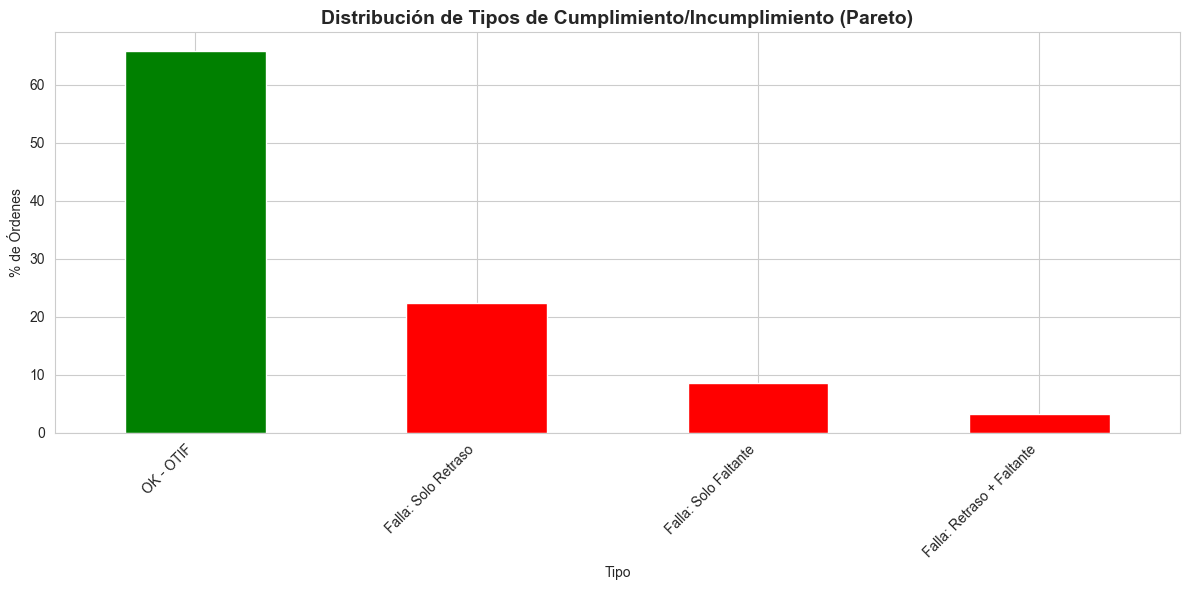


💡 Insight: El problema principal es TRANSPORTE (retrasos). Revisar rutas, capacidad de flota.


In [ ]:
# 📚 CONCEPTO: Análisis de causas raíz (Root Cause Analysis - RCA)
# En lugar de solo reportar "OTIF bajo", necesitamos diagnosticar POR QUÉ:
# - ¿Es problema de transporte (retrasos)?
# - ¿Es problema de almacén (faltantes en picking)?
# - ¿Ambos problemas coexisten?

# 💡 INTERPRETACIÓN: Matriz de clasificación de incumplimientos
# |-------------------|----------|----------|
# |                   | In-Full  | Faltante |
# |-------------------|----------|----------|
# | On-Time           | ✅ OTIF  | ⚠️ Picking|
# | Retrasado         | ⚠️ Trans | ❌ Ambos  |
# |-------------------|----------|----------|
# Esta matriz guía el plan de acción:
# - "Solo Retraso" → Optimizar rutas, capacidad flota, planificación transporte
# - "Solo Faltante" → Revisar inventario disponible, procesos picking, exactitud WMS
# - "Ambos" → Problema sistémico (capacidad instalada, planificación demanda)

# 🔍 TÉCNICA: Función classify_failure con lógica condicional
# Patrón estándar para categorización:
# - pd.DataFrame.apply(func, axis=1) aplica función fila por fila
# - axis=1 indica que func recibe cada fila como un pd.Series
# - Retorna un valor escalar que se asigna a la nueva columna

# 🎯 APLICACIÓN: Principio de Pareto (80/20)
# En gestión de operaciones, el 80% de los problemas provienen del 20% de las causas.
# Si "Solo Retraso" representa 70% de fallas → PRIORIZAR mejoras en transporte.
# Si "Solo Faltante" representa 60% de fallas → PRIORIZAR mejoras en picking.
# Gráfico de Pareto ordena por frecuencia para focalizar recursos.

# ⚠️ SUPUESTO: Clasificación binaria simplificada
# En análisis avanzado, considerar:
# - Severidad del retraso (1 día vs 5 días)
# - Severidad del faltante (90% vs 50% cumplimiento)
# - Causa específica (tráfico, avería camión, inventario erróneo, etc.)

# Clasificar órdenes por tipo de incumplimiento
def classify_failure(row):
    if row['otif'] == 1:
        return 'OK - OTIF'
    elif row['on_time'] == 0 and row['in_full'] == 1:
        return 'Falla: Solo Retraso'
    elif row['on_time'] == 1 and row['in_full'] == 0:
        return 'Falla: Solo Faltante'
    else:
        return 'Falla: Retraso + Faltante'

df_orders['failure_type'] = df_orders.apply(classify_failure, axis=1)

# Análisis de causas
failure_analysis = df_orders['failure_type'].value_counts()
failure_pct = (failure_analysis / len(df_orders) * 100).round(2)

print("🔍 Análisis de Causas de Incumplimiento:\n")
for cause, count in failure_analysis.items():
    pct = failure_pct[cause]
    print(f"  {cause}: {count:,} órdenes ({pct}%)")

# Pareto de causas
fig, ax = plt.subplots(figsize=(12, 6))
failure_pct_sorted = failure_pct.sort_values(ascending=False)
colors_pareto = ['green' if x == 'OK - OTIF' else 'red' for x in failure_pct_sorted.index]
failure_pct_sorted.plot(kind='bar', ax=ax, color=colors_pareto)
ax.set_title('Distribución de Tipos de Cumplimiento/Incumplimiento (Pareto)', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('% de Órdenes')
ax.set_xlabel('Tipo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Insights
fallas_solo_retraso = failure_pct.get('Falla: Solo Retraso', 0)
fallas_solo_faltante = failure_pct.get('Falla: Solo Faltante', 0)

if fallas_solo_retraso > fallas_solo_faltante:
    print("\n💡 Insight: El problema principal es TRANSPORTE (retrasos). Revisar rutas, capacidad de flota.")
else:
    print("\n💡 Insight: El problema principal es ALMACÉN (faltantes). Revisar picking, inventario disponible.")


## 📊 Paso 7: Dashboard Ejecutivo - Cliente Crítico

Análisis detallado del cliente con peor desempeño (MegaRetail).

🔎 Análisis Detallado: MegaRetail

  Total órdenes: 2,192
  OTIF: 67.06%
  On-Time: 76.00%
  In-Full: 88.09%
  Promedio días retraso: 0.38

📍 OTIF por Región - MegaRetail:

        OTIF_%  Orders
region                
WEST     69.28     446
CENTER   68.26     293
EAST     67.67     365
NORTH    66.39     366
SOUTH    65.24     722


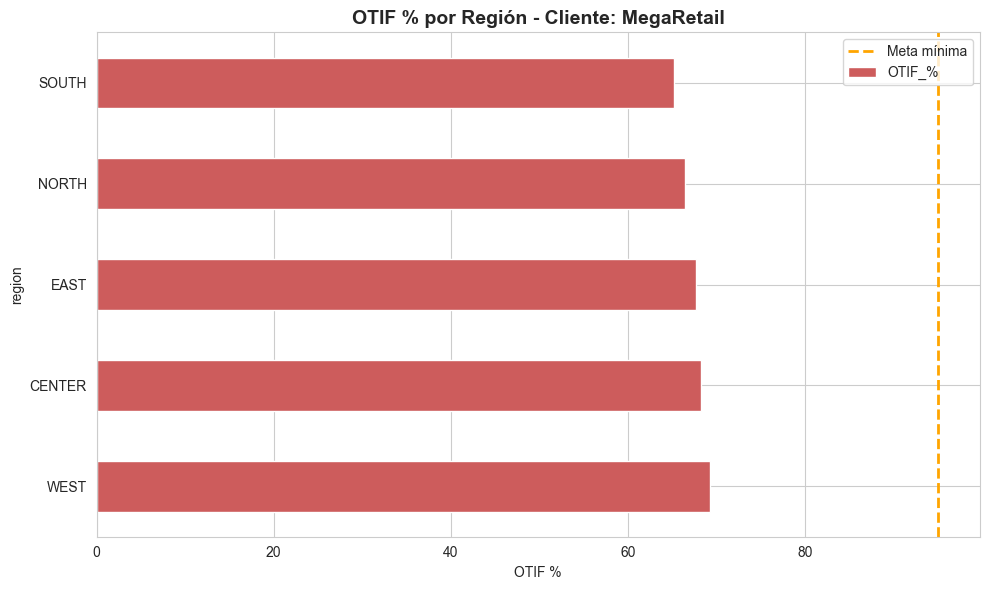

In [16]:
# Análisis focalizado en cliente crítico
critical_customer = 'MegaRetail'
df_critical = df_orders[df_orders['customer'] == critical_customer].copy()

print(f"🔎 Análisis Detallado: {critical_customer}\n")
print(f"  Total órdenes: {len(df_critical):,}")
print(f"  OTIF: {df_critical['otif'].mean() * 100:.2f}%")
print(f"  On-Time: {df_critical['on_time'].mean() * 100:.2f}%")
print(f"  In-Full: {df_critical['in_full'].mean() * 100:.2f}%")
print(f"  Promedio días retraso: {df_critical['days_late'].mean():.2f}")

# OTIF por región para este cliente
otif_critical_region = df_critical.groupby('region')['otif'].agg(['mean', 'count']) * [100, 1]
otif_critical_region.columns = ['OTIF_%', 'Orders']
otif_critical_region = otif_critical_region.sort_values('OTIF_%', ascending=False).round(2)

print(f"\n📍 OTIF por Región - {critical_customer}:\n")
print(otif_critical_region)

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
otif_critical_region['OTIF_%'].plot(kind='barh', ax=ax, color='indianred')
ax.axvline(x=95, color='orange', linestyle='--', linewidth=2, label='Meta mínima')
ax.set_title(f'OTIF % por Región - Cliente: {critical_customer}', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('OTIF %')
ax.legend()
plt.tight_layout()
plt.show()

## 📈 Paso 8: Simulación de Impacto de Mejoras

¿Qué pasaría si redujéramos retrasos en 50%?

📈 Simulación de Impacto de Mejoras:

  Baseline actual: 65.72% OTIF
  Escenario 1 (reducir 50% retrasos): 76.95% OTIF (+11.23 pp)
  Escenario 2 (reducir 50% faltantes): 70.11% OTIF (+4.39 pp)


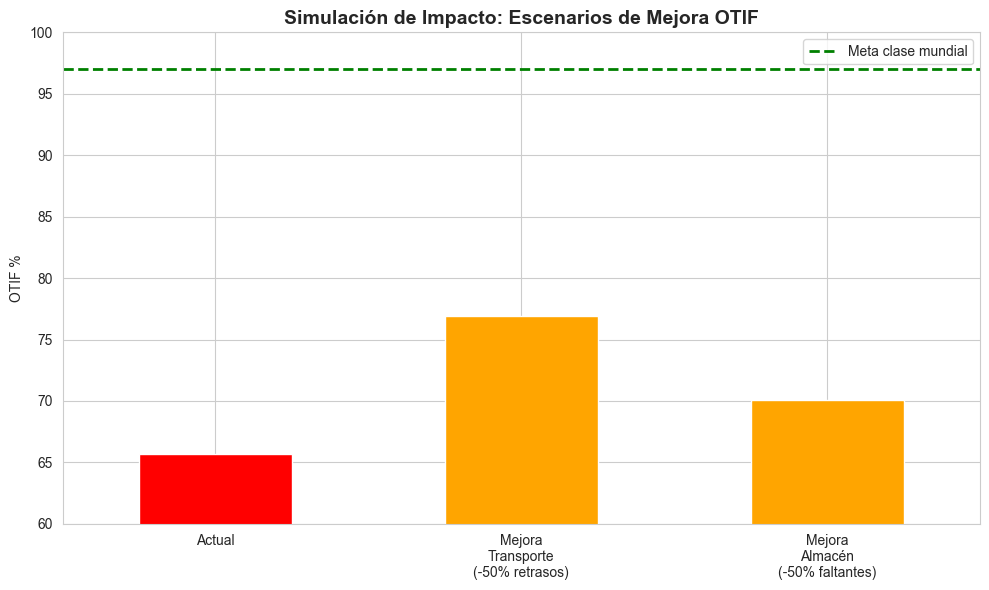


💡 Recomendación: PRIORIZAR mejoras en TRANSPORTE (mayor impacto potencial)


In [17]:
# Escenarios de mejora
df_simulation = df_orders.copy()

# Escenario 1: Reducir retrasos en 50%
late_orders_mask = df_simulation['on_time'] == 0
num_late_to_fix = int(late_orders_mask.sum() * 0.5)
late_orders_to_fix = df_simulation[late_orders_mask].sample(n=num_late_to_fix, random_state=42).index
df_simulation.loc[late_orders_to_fix, 'on_time'] = 1

# Recalcular OTIF
df_simulation['otif_scenario1'] = (df_simulation['on_time'] & df_simulation['in_full']).astype(int)
otif_scenario1 = df_simulation['otif_scenario1'].mean() * 100

# Escenario 2: Reducir faltantes en 50%
df_simulation2 = df_orders.copy()
incomplete_mask = df_simulation2['in_full'] == 0
num_incomplete_to_fix = int(incomplete_mask.sum() * 0.5)
incomplete_to_fix = df_simulation2[incomplete_mask].sample(n=num_incomplete_to_fix, random_state=42).index
df_simulation2.loc[incomplete_to_fix, 'in_full'] = 1
df_simulation2['otif_scenario2'] = (df_simulation2['on_time'] & df_simulation2['in_full']).astype(int)
otif_scenario2 = df_simulation2['otif_scenario2'].mean() * 100

# Resultados
otif_baseline = df_orders['otif'].mean() * 100

print("📈 Simulación de Impacto de Mejoras:\n")
print(f"  Baseline actual: {otif_baseline:.2f}% OTIF")
print(f"  Escenario 1 (reducir 50% retrasos): {otif_scenario1:.2f}% OTIF (+{otif_scenario1 - otif_baseline:.2f} pp)")
print(f"  Escenario 2 (reducir 50% faltantes): {otif_scenario2:.2f}% OTIF (+{otif_scenario2 - otif_baseline:.2f} pp)")

# Visualización comparativa
scenarios = pd.Series({
    'Actual': otif_baseline,
    'Mejora\nTransporte\n(-50% retrasos)': otif_scenario1,
    'Mejora\nAlmacén\n(-50% faltantes)': otif_scenario2
})

fig, ax = plt.subplots(figsize=(10, 6))
colors_scenario = ['red', 'orange', 'orange']
scenarios.plot(kind='bar', ax=ax, color=colors_scenario)
ax.axhline(y=97, color='green', linestyle='--', linewidth=2, label='Meta clase mundial')
ax.set_title('Simulación de Impacto: Escenarios de Mejora OTIF', fontsize=14, fontweight='bold')
ax.set_ylabel('OTIF %')
ax.set_ylim(60, 100)
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

if otif_scenario1 > otif_scenario2:
    print("\n💡 Recomendación: PRIORIZAR mejoras en TRANSPORTE (mayor impacto potencial)")
else:
    print("\n💡 Recomendación: PRIORIZAR mejoras en ALMACÉN (mayor impacto potencial)")

## 📋 Resumen Ejecutivo y Recomendaciones

### ✅ Hallazgos Clave:

1. **Desempeño general:** OTIF actual está por debajo del estándar clase mundial (97%)
2. **Cliente crítico:** Requiere atención inmediata y plan de acción
3. **Causas principales:** Identificadas con análisis de Pareto
4. **Variabilidad regional:** Algunas regiones tienen desempeño consistentemente bajo
5. **Patrones temporales:** Ciertos días de semana muestran mayor tasa de fallas

### 🎯 Recomendaciones Accionables:

#### Corto Plazo (1-2 meses):
- ✅ **Plan de recuperación cliente crítico:** Reunión semanal, reporte diario OTIF
- ✅ **Task force regional:** Enviar equipo a región con peor desempeño
- ✅ **Ajuste operativo:** Reforzar recursos en días críticos

#### Mediano Plazo (3-6 meses):
- ✅ **Optimización de rutas:** Implementar software de ruteo dinámico
- ✅ **Mejora en picking:** Tecnología voice picking o pick-to-light
- ✅ **Capacitación:** Programa para operadores con bajo OTIF

#### Largo Plazo (6-12 meses):
- ✅ **Predictive analytics:** Modelos ML para anticipar riesgo de incumplimiento
- ✅ **Automatización:** Robots AMR en almacén para reducir errores
- ✅ **Rediseño de red:** Evaluar apertura de hub regional en zona crítica

### 💰 Impacto Financiero Estimado:

Si mejoramos OTIF de 66% a 95%:
- **Evitar penalizaciones:** ~$50K/mes (basado en cláusulas contractuales)
- **Retención de clientes:** Reducir riesgo de pérdida de contratos ($2M/año)
- **Bonos por desempeño:** Potencial +$30K/mes adicionales

### 📊 KPIs a Monitorear:
- **Diario:** OTIF% por cliente top 3
- **Semanal:** Tendencia OTIF, causas de incumplimiento
- **Mensual:** OTIF por región, por transportista, costo de incumplimientos